In [3]:
from PIL import Image
from matplotlib import image
from matplotlib import pyplot as plt
from numpy import asarray
from sklearn.model_selection import train_test_split
import random

from keras.preprocessing.image import ImageDataGenerator

from os import listdir
import os

from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

Using TensorFlow backend.


In [4]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## Image Generation

In [5]:
image_gen = ImageDataGenerator(rotation_range=0, # rotate the image 0 degrees
                               width_shift_range=0.2, # Shift the pic width by a max of 10%
                               height_shift_range=0.2, # Shift the pic height by a max of 10%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.2, # Shear means cutting away part of the image (max 20%)
                               zoom_range=0.2, # Zoom in by 20% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

# Modelling

## Defining Image Dimention

In [6]:
# width,height,channels
image_shape = (256,256,3)

## Creating the Model #1

In [7]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=(256,256,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=32, kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=16, kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())

model.add(Dense(256, activation='relu'))
# randomly turn off 10% of neurons.
model.add(Dropout(0.1))


# Add a densely-connected layer with 128 neurons.
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))


# Add a densely-connected layer with 64 neurons.
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))


model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [8]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 64)      1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 125, 125, 32)      18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 60, 16)        4624      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 14400)            

### Training the Model: Attempt 1

In [9]:
batch_size = 16

train_image_gen = image_gen.flow_from_directory('./data/simple/processed/train/',
                                               target_size=image_shape[:2],
                                               batch_size=batch_size,
                                               class_mode='binary')

epoch_step = len(train_image_gen.filenames)//batch_size
print(epoch_step)

Found 3814 images belonging to 2 classes.
238


In [10]:
test_image_gen = image_gen.flow_from_directory('./data/simple/processed/test/',
                                               target_size=image_shape[:2],
                                               batch_size=batch_size,
                                               class_mode='binary')

valid_step = len(test_image_gen.filenames)//batch_size
print(valid_step)

Found 954 images belonging to 2 classes.
59


In [11]:
train_image_gen.class_indices

{'Contemporary': 0, 'Modern': 1}

In [12]:
test_image_gen.class_indices

{'Contemporary': 0, 'Modern': 1}

In [13]:
results = model.fit_generator(train_image_gen,epochs=30,
                              steps_per_epoch=epoch_step,
                              validation_data=test_image_gen,
                              validation_steps=valid_step,
                              verbose=1)

Epoch 1/30
238/238 [==============================] - 77s 322ms/step - loss: 0.6966 - accuracy: 0.5000 - val_loss: 0.6981 - val_accuracy: 0.4989
Epoch 2/30
238/238 [==============================] - 72s 303ms/step - loss: 0.6942 - accuracy: 0.4774 - val_loss: 0.6933 - val_accuracy: 0.4957
Epoch 3/30
238/238 [==============================] - 73s 305ms/step - loss: 0.6935 - accuracy: 0.4900 - val_loss: 0.6906 - val_accuracy: 0.5021
Epoch 4/30
238/238 [==============================] - 71s 298ms/step - loss: 0.6933 - accuracy: 0.5068 - val_loss: 0.6887 - val_accuracy: 0.5075
Epoch 5/30
238/238 [==============================] - 70s 295ms/step - loss: 0.6934 - accuracy: 0.4934 - val_loss: 0.6912 - val_accuracy: 0.5053
Epoch 6/30
238/238 [==============================] - 70s 294ms/step - loss: 0.6933 - accuracy: 0.4839 - val_loss: 0.6938 - val_accuracy: 0.4957
Epoch 7/30
238/238 [==============================] - 69s 291ms/step - loss: 0.6933 - accuracy: 0.4905 - val_loss: 0.6923 - val_ac

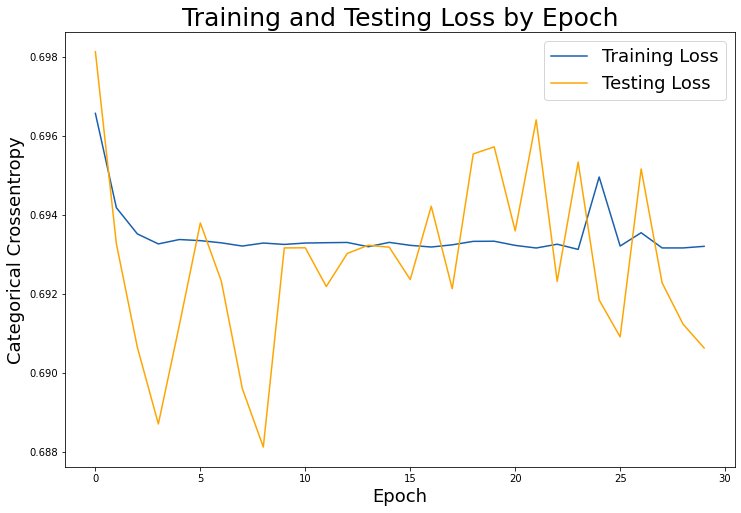

In [14]:
# Check out our train loss and test loss over epochs.
train_loss = results.history['loss']
test_loss = results.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)

plt.legend(fontsize = 18);

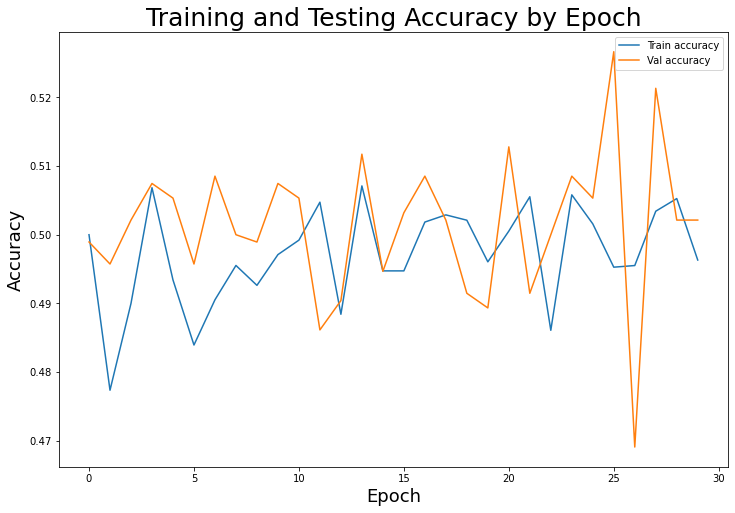

In [15]:
# Set figure size.
plt.figure(figsize=(12, 8))

plt.plot(results.history['accuracy'], label='Train accuracy')
plt.plot(results.history['val_accuracy'], label='Val accuracy')

# Set title
plt.title('Training and Testing Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)
plt.legend();

### Training the Model: Attempt 2

- increase batch size from 16 to 50

In [16]:
batch_size2 = 50

train_image_gen2 = image_gen.flow_from_directory('./data/simple/processed/train/',
                                               target_size=image_shape[:2],
                                               batch_size=batch_size2,
                                               class_mode='binary')

epoch_step = len(train_image_gen2.filenames)//batch_size2
print(epoch_step)

Found 3814 images belonging to 2 classes.
76


In [17]:
test_image_gen2 = image_gen.flow_from_directory('./data/simple/processed/test/',
                                               target_size=image_shape[:2],
                                               batch_size=batch_size2,
                                               class_mode='binary')

valid_step = len(test_image_gen2.filenames)//batch_size2
print(valid_step)

Found 954 images belonging to 2 classes.
19


In [18]:
train_image_gen2.class_indices

{'Contemporary': 0, 'Modern': 1}

In [19]:
test_image_gen2.class_indices

{'Contemporary': 0, 'Modern': 1}

In [20]:
results2 = model.fit_generator(train_image_gen2,epochs=30,
                              steps_per_epoch=epoch_step,
                              validation_data=test_image_gen2,
                              validation_steps=valid_step,
                              verbose=1)

Epoch 1/30
76/76 [==============================] - 65s 851ms/step - loss: 0.6931 - accuracy: 0.5027 - val_loss: 0.6935 - val_accuracy: 0.5042
Epoch 2/30
76/76 [==============================] - 70s 920ms/step - loss: 0.6931 - accuracy: 0.5040 - val_loss: 0.6932 - val_accuracy: 0.5022
Epoch 3/30
76/76 [==============================] - 68s 897ms/step - loss: 0.6931 - accuracy: 0.5024 - val_loss: 0.6946 - val_accuracy: 0.4967
Epoch 4/30
76/76 [==============================] - 68s 894ms/step - loss: 0.6931 - accuracy: 0.5048 - val_loss: 0.6939 - val_accuracy: 0.5044
Epoch 5/30
76/76 [==============================] - 66s 866ms/step - loss: 0.6931 - accuracy: 0.5048 - val_loss: 0.6942 - val_accuracy: 0.5055
Epoch 6/30
76/76 [==============================] - 64s 848ms/step - loss: 0.6932 - accuracy: 0.5021 - val_loss: 0.6939 - val_accuracy: 0.5055
Epoch 7/30
76/76 [==============================] - 63s 829ms/step - loss: 0.6931 - accuracy: 0.5058 - val_loss: 0.6906 - val_accuracy: 0.4978

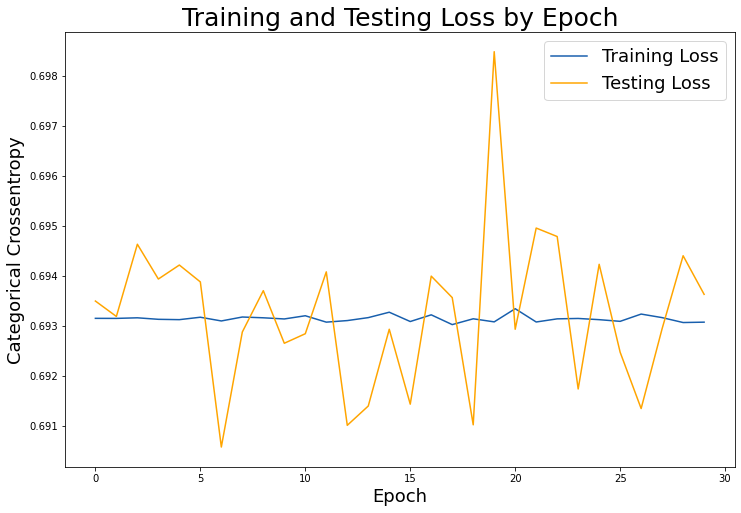

In [21]:
# Check out our train loss and test loss over epochs.
train_loss = results2.history['loss']
test_loss = results2.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)

plt.legend(fontsize = 18);

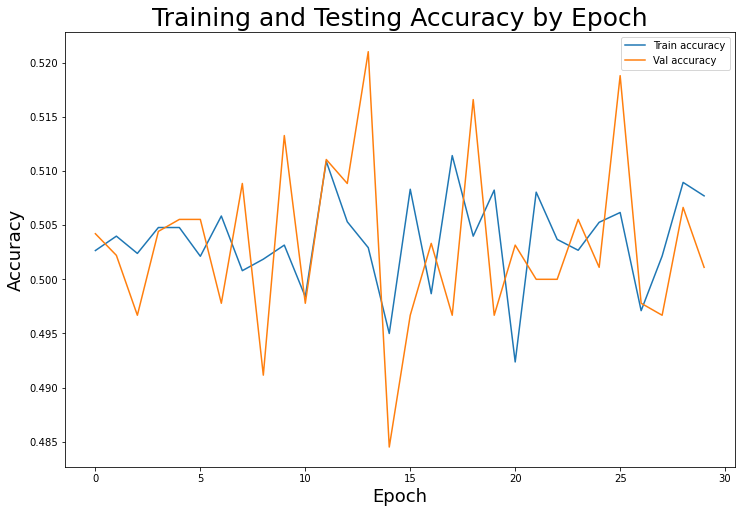

In [22]:
# Set figure size.
plt.figure(figsize=(12, 8))

plt.plot(results2.history['accuracy'], label='Train accuracy')
plt.plot(results2.history['val_accuracy'], label='Val accuracy')

# Set title
plt.title('Training and Testing Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)
plt.legend();

## Creating the Model #2

- model without dropouts because not much overfitting detected in model #1

In [23]:
model2 = Sequential()

model2.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=(256,256,3), activation='relu',))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(filters=32, kernel_size=(3,3),activation='relu',))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(filters=16, kernel_size=(3,3),activation='relu',))
model2.add(MaxPooling2D(pool_size=(2, 2)))


model2.add(Flatten())

model2.add(Dense(256, activation='relu'))

# Dropouts help reduce overfitting by randomly turning neurons off during training.
# Here we say randomly turn off 10% of neurons.
#model2.add(Dropout(0.1))

# Add a densely-connected layer with 128 neurons.
model2.add(Dense(128, activation='relu'))

# Let's try to avoid overfitting!
#model2.add(Dropout(0.1))

# Add a densely-connected layer with 64 neurons.
model2.add(Dense(64, activation='relu'))

# Let's try to avoid overfitting!
#model2.add(Dropout(0.1))


# Last layer, remember its binary, 0=cat , 1=dog
model2.add(Dense(1))
model2.add(Activation('sigmoid'))

model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [24]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 254, 254, 64)      1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 125, 125, 32)      18464     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 60, 60, 16)        4624      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 14400)            

### Training the Model: Attempt 1

In [25]:
batch_size = 16

train_image_gen = image_gen.flow_from_directory('./data/simple/processed/train/',
                                               target_size=image_shape[:2],
                                               batch_size=batch_size,
                                               class_mode='binary')

epoch_step = len(train_image_gen.filenames)//batch_size
print(epoch_step)

Found 3814 images belonging to 2 classes.
238


In [26]:
test_image_gen = image_gen.flow_from_directory('./data/simple/processed/test/',
                                               target_size=image_shape[:2],
                                               batch_size=batch_size,
                                               class_mode='binary')

valid_step = len(test_image_gen.filenames)//batch_size
print(valid_step)

Found 954 images belonging to 2 classes.
59


In [27]:
train_image_gen.class_indices

{'Contemporary': 0, 'Modern': 1}

In [28]:
test_image_gen.class_indices

{'Contemporary': 0, 'Modern': 1}

In [29]:
results = model2.fit_generator(train_image_gen,epochs=30,
                              steps_per_epoch=epoch_step,
                              validation_data=test_image_gen,
                              validation_steps=valid_step,
                              verbose=1)

Epoch 1/30
238/238 [==============================] - 69s 292ms/step - loss: 0.6941 - accuracy: 0.4913 - val_loss: 0.6928 - val_accuracy: 0.5021
Epoch 2/30
238/238 [==============================] - 71s 299ms/step - loss: 0.6933 - accuracy: 0.4934 - val_loss: 0.6931 - val_accuracy: 0.5064
Epoch 3/30
238/238 [==============================] - 71s 299ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6938 - val_accuracy: 0.5011
Epoch 4/30
238/238 [==============================] - 71s 297ms/step - loss: 0.6934 - accuracy: 0.4989 - val_loss: 0.6954 - val_accuracy: 0.5053
Epoch 5/30
238/238 [==============================] - 70s 294ms/step - loss: 0.6935 - accuracy: 0.5008 - val_loss: 0.6933 - val_accuracy: 0.4936
Epoch 6/30
238/238 [==============================] - 69s 292ms/step - loss: 0.6934 - accuracy: 0.4842 - val_loss: 0.6928 - val_accuracy: 0.5043
Epoch 7/30
238/238 [==============================] - 69s 292ms/step - loss: 0.6932 - accuracy: 0.4989 - val_loss: 0.6961 - val_ac

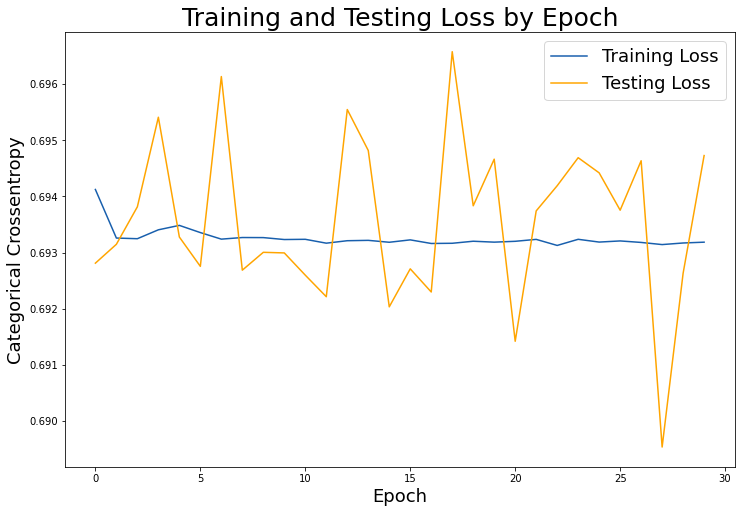

In [30]:
# Check out our train loss and test loss over epochs.
train_loss = results.history['loss']
test_loss = results.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)

plt.legend(fontsize = 18);

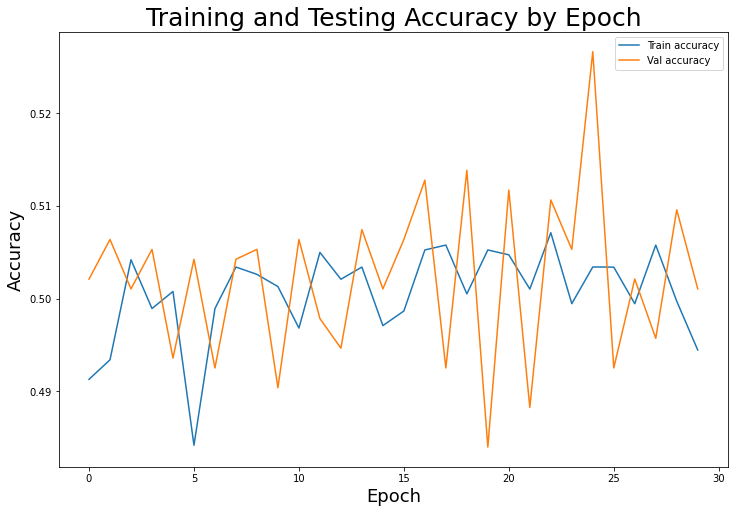

In [31]:
# Set figure size.
plt.figure(figsize=(12, 8))

plt.plot(results.history['accuracy'], label='Train accuracy')
plt.plot(results.history['val_accuracy'], label='Val accuracy')

# Set title
plt.title('Training and Testing Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)
plt.legend();